# Simulation study CE vs. EIS bias/variance/rho

## imports

In [1]:
import jax
from jax import vmap
import jax.numpy as jnp
import jax.random as jrn
from functools import partial
from jaxtyping import Array, Float

import matplotlib.pyplot as plt
import pandas as pd

from isssm.lcssm import nb_lcssm, simulate_lcssm
from isssm.mode_estimation import mode_estimation
from isssm.modified_efficient_importance_sampling import modified_efficient_importance_sampling
from isssm.ce_method import (
    ce_cholesky_precision, 
    marginals,
    simulate as simulate_ce,
    ce_log_weights,
    forward_model_markov_process
)
from isssm.importance_sampling import ess_pct
from isssm.importance_sampling import lcssm_importance_sampling
from isssm.kalman import kalman, smoother
from tensorflow_probability.substrates.jax.distributions import WishartTriL as Wishart
from isssm.lcssm import poisson_lcssm
from isssm.kalman import kalman
from isssm.importance_sampling import log_weights_t
from isssm.glssm import vmatmul
from tensorflow_probability.substrates.jax.distributions import (
    MultivariateNormalFullCovariance as MVN,
)
from ipywidgets import IntProgress
from IPython.display import display

key = jrn.PRNGKey(342234)

2024-05-23 10:50:14.837516: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-23 10:50:14.837540: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-23 10:50:14.837546: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Efficient calculation of weights

In [2]:
def log_weights_ssm(y, x0, A, B, Sigma, z, Omega, dist, xi, N, key):
    """Calculate the efficiency factor while sampling only the marginal distributions, keeping memory impact minimal"""
    x_filt, Xi_filt, x_pred, Xi_pred = kalman(z, x0, Sigma, Omega, A, B)

    def _sample_and_weights(carry, inputs):
        X_smooth_next, log_w, key = carry
        x_filt, Xi_filt, Xi_pred, A_t, B_t, y_t, xi_t, z_t, Omega_t = inputs

        G = Xi_filt @ jnp.linalg.solve(Xi_pred, A_t).T

        cond_expectation = x_filt + vmatmul(G, X_smooth_next - (A_t @ x_filt)[None])
        cond_covariance = Xi_filt - G @ Xi_pred @ G.T

        key, subkey = jrn.split(key)
        new_samples = MVN(cond_expectation, cond_covariance).sample(seed=subkey)

        s_t = vmap(jnp.matmul, (None, 0))(B_t, new_samples)
        log_w = log_w + vmap(
            partial(
                log_weights_t, y_t=y_t, xi_t=xi_t, dist=dist, z_t=z_t, Omega_t=Omega_t
            )
        )(s_t)

        return (new_samples, log_w, key), jnp.empty((0,))

    key, subkey = jrn.split(key)

    initial_samples = MVN(x_filt[-1], Xi_filt[-1]).sample(N, seed=subkey)
    initial_signals = vmap(jnp.matmul, (None, 0))(B[-1], initial_samples)
    initial_log_weights = vmap(
        partial(
            log_weights_t,
            y_t=y[-1],
            xi_t=xi[-1],
            dist=dist,
            z_t=z[-1],
            Omega_t=Omega[-1],
        )
    )(initial_signals)

    (_, log_weights, _), _ = jax.lax.scan(
        _sample_and_weights,
        (initial_samples, initial_log_weights, subkey),
        (
            x_filt[:-1],
            Xi_filt[:-1],
            Xi_pred[1:],
            A,
            B[:-1],
            y[:-1],
            xi[:-1],
            z[:-1],
            Omega[:-1],
        ),
        reverse=True,
    )

    return log_weights

#ess_pct(log_weights_ssm(Y, x0, A_t, B, Sigma, z_la, Omega_la, dist, xi, N_true, subkey)), results_la.mean()["ef"]

## simulation code

In [19]:
def eis_marginals(x0, A, Sigma, B, z, Omega):
    x_filt, Xi_filt, x_pred, Xi_pred = kalman(z, x0, Sigma, Omega, A, B)
    x_smooth, Xi_smooth = smoother(x_filt, Xi_filt, x_pred, Xi_pred, A)
    
    marg_means = x_smooth
    marg_vars = vmap(jnp.diag)(Xi_smooth)

    return marg_means, marg_vars

def eis_single_outcome(key, N, Y, x0, A, Sigma, B, dist, xi, z_la, Omega_la):
    key, subkey = jrn.split(key)
    z_eis, Omega_eis = modified_efficient_importance_sampling(
        Y, x0, A, Sigma, B, xi, dist, z_la, Omega_la, 1, N, subkey
    )

    key, subkey = jrn.split(key)
    _, log_weights = lcssm_importance_sampling(
        Y, x0, A, Sigma, B, dist, xi, z_eis, Omega_eis, N, subkey
    )

    return *(eis_marginals(x0, A, Sigma, B, z_eis, Omega_eis)), ess_pct(log_weights)

def ce_single_outcome(key, N, Y, x0, A, Sigma, B, dist, xi, z_la, Omega_la):
    key, subkey = jrn.split(key)
    
    samples, log_weights = lcssm_importance_sampling(Y, x0, A, Sigma, B, dist, xi, z_la, Omega_la, N, subkey)

    initial_mean, (initial_diag, initial_off_diag) = forward_model_markov_process(z_la, x0, A, B, Sigma, Omega_la)

    (diag, off_diag, mean), _, _ = ce_cholesky_precision(Y, x0, A, Sigma, B, xi, dist, initial_mean, initial_diag, initial_off_diag, 1, N, subkey)

    key, subkey = jrn.split(key)
    samples = simulate_ce(
        diag, off_diag, subkey, N
    )

    log_weights = vmap(partial(ce_log_weights,
        y=Y, full_diag=diag, off_diag=off_diag, mean=mean, x0=x0, A=A, Sigma=Sigma, B=B, dist=dist, xi=xi
    ))(samples)

    return *(marginals(mean, diag, off_diag)), ess_pct(log_weights)

def bias_var(
    samples: Float[Array, "M ..."],
    true: Float[Array, "..."]
):
    bias_sr = (samples - true)**2
    var = (samples - samples.mean(axis=0)) ** 2
    return bias_sr, var

def eis_outcomes(N, key, M, true_z, true_Omega, Y, x0, A, Sigma, B, dist, xi, z_la, Omega_la):
    key, *subkeys = jrn.split(key, M+1)
    subkeys = jnp.array(subkeys)

    true_mean, true_var = eis_marginals(x0, A, Sigma, B, true_z, true_Omega)

    single_run = partial(eis_single_outcome, Y=Y, N=N, x0=x0, A=A, Sigma=Sigma, B=B, dist=dist, xi=xi, z_la=z_la, Omega_la=Omega_la)
    marg_means, marg_vars, ef = vmap(single_run)(subkeys)
        
    mean_bias, mean_var = bias_var(marg_means, true_mean)
    var_bias, var_var = bias_var(marg_vars, true_var)

    return pd.DataFrame({
        "N": int(N),
        "N_mse": M,
        "mean_bias": mean_bias.mean(axis=(-2, -1)),
        "mean_var": mean_var.mean(axis=(-2,-1)),
        "var_bias": var_bias.mean(axis=(-2,-1)),
        "var_var": var_var.mean(axis=(-2,-1)),
        "ef": ef,
    })

def ce_outcomes(N, key, M, true_mean, true_diag, true_off_diag, Y, x0, A, Sigma, B, dist, xi, z_la, Omega_la):
    key, *subkeys = jrn.split(key, M+1)
    subkeys = jnp.array(subkeys)

    true_mean, true_var = marginals(true_mean, true_diag, true_off_diag)

    single_run = partial(ce_single_outcome, N=N, Y=Y,x0=x0, A=A, Sigma=Sigma, B=B, dist=dist, xi=xi, z_la=z_la, Omega_la=Omega_la)

    marg_means, marg_vars, ef = vmap(single_run)(subkeys)
        
    mean_bias, mean_var = bias_var(marg_means, true_mean)
    var_bias, var_var = bias_var(marg_vars, true_var)

    return pd.DataFrame({
        "N": int(N),
        "N_mse": M,
        "mean_bias": mean_bias.mean(axis=(-2,-1)),
        "mean_var": mean_var.mean(axis=(-2,-1)),
        "var_bias": var_bias.mean(axis=(-2,-1)),
        "var_var": var_var.mean(axis=(-2,-1)),
        "ef": ef,
    })

## setup

In [3]:
x0 = jnp.zeros(1)
n = 20
alpha = .5
A_t = alpha * jnp.tile(jnp.eye(1)[None,:,:], (n, 1, 1))
Sigma = (1 - alpha ** 2) * jnp.tile(jnp.eye(1)[None,:,:], (n + 1, 1, 1))

# NB observations 

nb_model = nb_lcssm(
    x0,
    A_t,
    Sigma,
    jnp.tile(jnp.eye(1)[None, :,:], (n + 1, 1, 1)),
    .1
)
x0, A_t, Sigma, B, dist, xi = nb_model

key, subkey = jrn.split(key)
(X,), (Y,) = simulate_lcssm(*nb_model, 1, subkey)

s_init = vmap(jnp.dot)(B, X)
X_smooth, z_la, Omega_la = mode_estimation(Y, x0, A_t, Sigma, B, dist, xi, s_init, 10)

# more will result in OOMs
N_true = int(1.5 * 1e6)
M = 100
Ns = jnp.logspace(1,3.5,10).astype(jnp.int32)

## LA simulation

In [4]:
key, subkey_run = jrn.split(key)

def la_single_outcome(key, N, Y, x0, A, Sigma, B, dist, xi, z, Omega):
    _, log_weights = lcssm_importance_sampling(Y, x0, A, Sigma, B, dist, xi, z, Omega, N, key)
    return ess_pct(log_weights)

def la_outcomes(N, key, M, Y, x0, A, Sigma, B, dist, xi, z_la, Omega_la):
    key, *subkeys = jrn.split(key, M+1)
    subkeys = jnp.array(subkeys)

    single_run = partial(la_single_outcome, N=N, Y=Y,x0=x0, A=A, Sigma=Sigma, B=B, dist=dist, xi=xi, z=z_la, Omega=Omega_la)

    ef = vmap(single_run)(subkeys)

    return pd.DataFrame({
        "N": int(N),
        "N_mse": M,
        "mean_bias": None,
        "mean_var": None,
        "var_bias": None,
        "var_var": None,
        "ef": ef,
    })

results_la = pd.concat([
    la_outcomes(N, subkey_run, M, Y, x0, A_t, Sigma, B, dist, xi, z_la, Omega_la)
    for N in Ns
]).reset_index(drop=True)

## EIS simulation

In [5]:
key, subkey = jrn.split(key)
true_z_eis, true_omega_eis = modified_efficient_importance_sampling(
    Y, x0, A_t, Sigma, B, xi, dist, z_la, Omega_la, 1, N_true, subkey,
)

In [6]:
single_N_run_eis = partial(
    eis_outcomes, 
    Y=Y, key=subkey_run, M=M, true_z=true_z_eis, true_Omega=true_omega_eis, x0=x0, A=A_t, Sigma=Sigma, B=B, dist=dist, xi=xi, z_la=z_la, Omega_la=Omega_la
)

results_eis = pd.concat([
    single_N_run_eis(N) for N in Ns
]).reset_index(drop=True)


## CE simulation

In [7]:
key, subkey = jrn.split(key)
samples_la, log_weights_la = lcssm_importance_sampling(
    Y, x0, A_t, Sigma, B, dist, xi, z_la, Omega_la, N_true, subkey
)

key, subkey = jrn.split(key)
initial_mean, (initial_diag, initial_off_diag) = forward_model_markov_process(z_la, x0, A_t, B, Sigma, Omega_la)
# getting XLA error otherwise
with jax.default_device(jax.devices("cpu")[0]):
    (true_diag, true_off_diag, true_mu), (_, log_weights_ce), _ = ce_cholesky_precision(
        Y, x0, A_t, Sigma, B, xi, dist, initial_mean, initial_diag, initial_off_diag, 1, N_true, subkey
    )

In [8]:
single_N_run_ce = partial(
    ce_outcomes, 
    Y=Y, key=subkey_run, N_mse=M, true_mean=true_mu, true_diag=true_diag, true_off_diag=true_off_diag, x0=x0, A=A_t, Sigma=Sigma, B=B, dist=dist, xi=xi, z_la=z_la, Omega_la=Omega_la
)

results_ce = pd.concat([
    single_N_run_ce(N) for N in Ns
]).reset_index(drop=True)

## inspect true solutions

In [9]:
_, log_weights_eis = lcssm_importance_sampling(Y, x0, A_t, Sigma, B, dist, xi, true_z_eis, true_omega_eis, N_true, subkey)
ess_pct(log_weights_la), ess_pct(log_weights_ce), ess_pct(log_weights_eis)

(Array(99.18389385, dtype=float64),
 Array(99.77554809, dtype=float64),
 Array(99.78012264, dtype=float64))

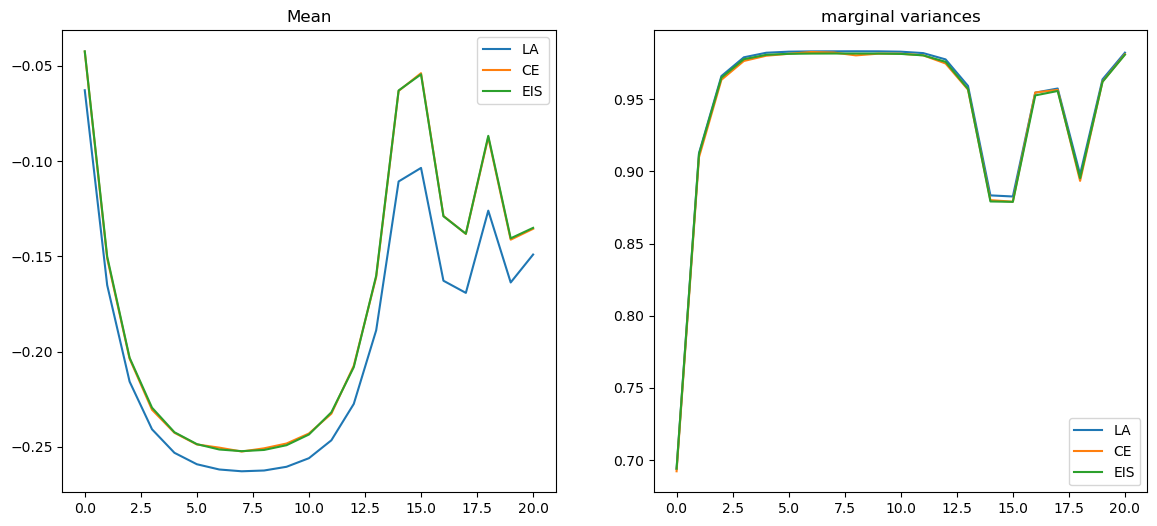

In [10]:
ce_true_mu, ce_true_var = marginals(true_mu, true_diag, true_off_diag)
eis_true_mu, eis_true_var = eis_marginals(x0, A_t, Sigma, B, true_z_eis, true_omega_eis)
la_mu, la_var = eis_marginals(x0, A_t, Sigma, B, z_la, Omega_la)


fig, axs = plt.subplots(1,2, figsize=(14,6))

axs[0].set_title("Mean")
axs[0].plot(la_mu[:,0], label="LA")
axs[0].plot(ce_true_mu[:,0], label="CE")
axs[0].plot(eis_true_mu[:,0], label="EIS")
axs[0].legend()
axs[1].set_title("marginal variances")
axs[1].plot(la_var[:,0], label="LA")
axs[1].plot(ce_true_var[:,0], label="CE")
axs[1].plot(eis_true_var[:,0], label="EIS")
axs[1].legend()
plt.show()

## simulation results

In [11]:
import seaborn as sns
results_eis

,N,N_mse,mean_bias,mean_var,var_bias,var_var,ef
0,10,100,2.493071e-04,9.245159e-05,1.601086e-04,1.737175e-04,99.526637
1,10,100,2.039639e-04,1.445876e-05,7.675667e-05,7.279853e-05,99.883174
2,10,100,1.813451e-04,3.406173e-05,9.023990e-05,7.823291e-05,99.813548
3,10,100,1.874421e-04,1.589622e-05,1.033920e-04,1.200959e-04,99.879167
4,10,100,3.143126e-04,4.965315e-05,1.233423e-04,1.303480e-04,96.281030
...,...,...,...,...,...,...,...
995,3162,100,2.874495e-07,2.178808e-07,1.267212e-06,1.210763e-06,99.772152
996,3162,100,1.912870e-08,2.473438e-08,1.308759e-06,1.037496e-06,99.774445
997,3162,100,1.843290e-07,1.542400e-07,1.603958e-06,1.537533e-06,99.782021
998,3162,100,9.460597e-08,7.615242e-08,7.292288e-07,7.513534e-07,99.781592


In [12]:
results = pd.concat([
    results_la.assign(method="LA"),
    results_eis.assign(method="EIS"), 
    results_ce.assign(method="CE")
])
results.to_csv("../../data/figures/03_state_space_models/compare_ce_eis_mse.csv", index=False)

/tmp/ipykernel_2164959/409058690.py:1: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([


<Axes: xlabel='N', ylabel='ef'>

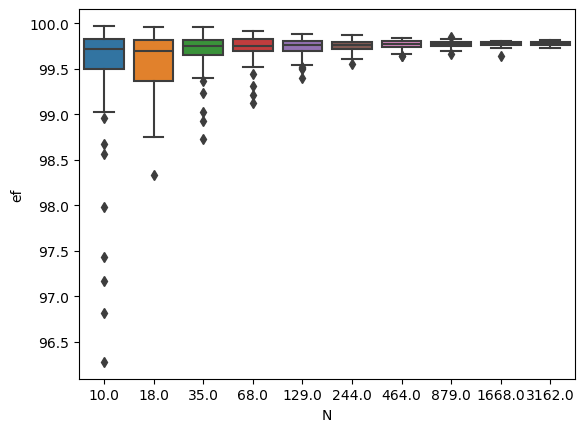

In [13]:
results_eis["N"] = results_eis["N"].astype(jnp.float64)
sns.boxplot(results_eis, x="N", y="ef")

## Optimum analysis: efficiency factors

In [ ]:
df_ef = pd.DataFrame({"N": {}, "method": {}, "ef": {}})
(n_iter_la, n_iter_eis, n_iter_ce) = (10, 10, 10)

key, *subkeys_large = jrn.split(key, 3)
subkeys_large = jnp.array(subkeys_large)

for subkey in subkeys_large:
    n = 10
    N_true = int(1.5 * 1e6 / n)
    x0 = jnp.zeros(1)
    alpha = 0.5
    A = alpha * jnp.tile(jnp.eye(1)[None, :, :], (n, 1, 1))
    Sigma = (1 - alpha**2) * jnp.tile(jnp.eye(1)[None, :, :], (n + 1, 1, 1))

    # NB observations
    model = nb_lcssm(x0, A, Sigma, jnp.tile(jnp.eye(1)[None, :, :], (n + 1, 1, 1)), 0.1)
    # model = poisson_lcssm(
    #    x0,
    #    A,
    #    Sigma,
    #    jnp.tile(jnp.eye(1)[None, :,:], (n + 1, 1, 1)),
    # )
    x0, A, Sigma, B, dist, xi = model

    key, subkey = jrn.split(key)
    (X,), (Y,) = simulate_lcssm(*model, 1, subkey)
    X_smooth, z_la, Omega_la = mode_estimation(
        Y, x0, A, Sigma, B, dist, xi, X, n_iter_la
    )
    true_z_eis, true_omega_eis = modified_efficient_importance_sampling(
        Y,
        x0,
        A,
        Sigma,
        B,
        xi,
        dist,
        z_la,
        Omega_la,
        n_iter_eis,
        N_true,
        subkey,
    )

    log_weights_eis = log_weights_ssm(Y, x0, A, B, Sigma, true_z_eis, true_omega_eis, dist, xi, N_true, subkey)

    log_weights_la = log_weights_ssm(Y, x0, A, B, Sigma, z_la, Omega_la, dist, xi, N_true, subkey)
    #_, log_weights_la = lcssm_importance_sampling(
    #    Y, x0, A, Sigma, B, dist, xi, z_la, Omega_la, N_true, subkey
    #)

    key, subkey = jrn.split(key)

    initial_mean, (initial_diag, initial_off_diag) = forward_model_markov_process(
        z_la, x0, A, B, Sigma, Omega_la
    )
    _, (_, log_weights_ce), _ = ce_cholesky_precision(
        Y,
        x0,
        A,
        Sigma,
        B,
        xi,
        dist,
        initial_mean,
        initial_diag,
        initial_off_diag,
        n_iter_ce,
        N_true,
        subkey,
    )

    df_ef = pd.concat(
        [
            df_ef,
            pd.DataFrame(
                {
                    "N": N_true,
                    "method": ["LA", "EIS", "CE"],
                    "ef": [
                        ess_pct(log_weights_la),
                        ess_pct(log_weights_eis),
                        ess_pct(log_weights_ce),
                    ],
                }
            ),
        ]
    )

df_ef.to_csv("../../data/figures/03_state_space_models/ef_large_N.csv", index=False)

/tmp/ipykernel_2164959/2327031721.py:73: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  df_ef = pd.concat(


In [3]:
df_state_dimensions = pd.DataFrame({
    "N": {},
    "m": {},
    "n": {},
    "method": {},
    "ef": {}
})

(n_iter_la, n_iter_eis, n_iter_ce) = (100, 100, 100)

M = 3
key, *subkeys_large = jrn.split(key, M + 1)
subkeys_large = jnp.array(subkeys_large)

ms = jnp.array([2,4,8,16,32])
n = 10

progress_bar = IntProgress(min=0, max = M * len(ms))
display(progress_bar)

for j in range(M):
    key = subkeys_large[j]
    for m in ms:
        progress_bar.description = f"m={m}({j+1}/{M})"

        # prevent OOM, smaller N for larger n
        N_true = int(1e6)
        x0 = jnp.zeros(m)
        alpha = .5
        A = alpha * jnp.tile(jnp.eye(m)[None,:,:], (n, 1, 1))
        key, subkey = jrn.split(key)
        innovation_cov = Wishart(df=1.1 * m, scale_tril=jnp.eye(m)).sample(seed=subkey)
        Sigma = 1/(1 - alpha ** 2) * jnp.tile(innovation_cov[None,:,:], (n + 1, 1, 1))

        # NB observations 
        model = nb_lcssm(
            x0,
            A,
            Sigma,
            jnp.tile(jnp.eye(m)[None, :,:], (n + 1, 1, 1)),
            .1
        )
        x0, A, Sigma, B, dist, xi = model

        key, subkey = jrn.split(key)
        (X,), (Y,) = simulate_lcssm(*model, 1, subkey)

        s_init = vmap(jnp.dot)(B, X)
        X_smooth, z_la, Omega_la = mode_estimation(Y, x0, A, Sigma, B, dist, xi, s_init, n_iter_la)

        key, subkey = jrn.split(key)
        true_z_eis, true_omega_eis = modified_efficient_importance_sampling(
            Y, x0, A, Sigma, B, xi, dist, z_la, Omega_la, n_iter_ce, N_true, subkey,
        )

        key, subkey = jrn.split(key)

        log_weights_la = log_weights_ssm(Y, x0, A, B, Sigma, z_la, Omega_la, dist, xi, N_true, subkey)
        log_weights_eis = log_weights_ssm(Y, x0, A, B, Sigma, true_z_eis, true_omega_eis, dist, xi, N_true, subkey)
        # large simulations don't fit on GPU (yet)
        with jax.default_device(jax.devices("cpu")[0]):
            initial_mean, (initial_diag, initial_off_diag) = forward_model_markov_process(
                z_la, x0, A, B, Sigma, Omega_la
            )
        #with jax.default_device(jax.devices("cpu")[0]):
            _, (_, log_weights_ce), _ = ce_cholesky_precision(
                Y,
                x0,
                A,
                Sigma,
                B,
                xi,
                dist,
                initial_mean,
                initial_diag,
                initial_off_diag,
                n_iter_ce,
                N_true,
                subkey,
            )

        df_state_dimensions = pd.concat([
                df_state_dimensions,
                pd.DataFrame({
                    "N": N_true,
                    "m": m,
                    "j": j,
                    "n": n,
                    "method": ["LA", "EIS", "CE"],
                    "ef": [ess_pct(log_weights_la), ess_pct(log_weights_eis), ess_pct(log_weights_ce)]
                })
            ])
        
        df_state_dimensions.to_csv("../../data/figures/03_state_space_models/ef_state_dimensions.csv", index=False)
        progress_bar.value += 1

IntProgress(value=0, max=15)

/tmp/ipykernel_2366657/867018030.py:81: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  df_state_dimensions = pd.concat([


In [ ]:
from isssm.lcssm import poisson_lcssm
df_dimensions = pd.DataFrame({
    "N": {},
    "m": {},
    "n": {},
    "method": {},
    "ef": {}
})

(n_iter_la, n_iter_eis, n_iter_ce) = (100, 100, 100)

M = 100
key, *subkeys_large = jrn.split(key, M + 1)
subkeys_large = jnp.array(subkeys_large)

ns = jnp.array([10, 20, 40, 80, 160])

for j in range(M):
    key = subkeys_large[j]
    for n in ns:

        # prevent OOM, smaller N for larger n
        N_true = int(1e6)
        x0 = jnp.zeros(1)
        alpha = .5
        A = alpha * jnp.tile(jnp.eye(1)[None,:,:], (n, 1, 1))
        Sigma = (1 - alpha ** 2) * jnp.tile(jnp.eye(1)[None,:,:], (n + 1, 1, 1))

        # NB observations 
        model = nb_lcssm(
            x0,
            A,
            Sigma,
            jnp.tile(jnp.eye(1)[None, :,:], (n + 1, 1, 1)),
            .1
        )
        #model = poisson_lcssm(
        #    x0,
        #    A,
        #    Sigma,
        #    jnp.tile(jnp.eye(1)[None, :,:], (n + 1, 1, 1)),
        #)
        x0, A, Sigma, B, dist, xi = model

        key, subkey = jrn.split(key)
        (X,), (Y,) = simulate_lcssm(*model, 1, subkey)
        n,m = X.shape

        s_init = vmap(jnp.dot)(B, X)
        X_smooth, z_la, Omega_la = mode_estimation(Y, x0, A, Sigma, B, dist, xi, s_init, n_iter_la)

        key, subkey = jrn.split(key)
        true_z_eis, true_omega_eis = modified_efficient_importance_sampling(
            Y, x0, A, Sigma, B, xi, dist, z_la, Omega_la, n_iter_ce, N_true, subkey,
        )

        key, subkey = jrn.split(key)

        log_weights_la = log_weights_ssm(Y, x0, A, B, Sigma, z_la, Omega_la, dist, xi, N_true, subkey)
        log_weights_eis = log_weights_ssm(Y, x0, A, B, Sigma, true_z_eis, true_omega_eis, dist, xi, N_true, subkey)
        # large simulations don't fit on GPU (yet)
        with jax.default_device(jax.devices("cpu")[0]):
            initial_mean, (initial_diag, initial_off_diag) = forward_model_markov_process(
                z_la, x0, A, B, Sigma, Omega_la
            )
        #with jax.default_device(jax.devices("cpu")[0]):
            _, (_, log_weights_ce), _ = ce_cholesky_precision(
                Y,
                x0,
                A,
                Sigma,
                B,
                xi,
                dist,
                initial_mean,
                initial_diag,
                initial_off_diag,
                n_iter_ce,
                N_true,
                subkey,
            )

        df_dimensions = pd.concat([
                df_dimensions,
                pd.DataFrame({
                    "N": N_true,
                    "m": m,
                    "j": j,
                    "n": n,
                    "method": ["LA", "EIS", "CE"],
                    "ef": [ess_pct(log_weights_la), ess_pct(log_weights_eis), ess_pct(log_weights_ce)]
                })
            ])
        
        df_dimensions.to_csv("../../data/figures/03_state_space_models/ef_dimensions.csv", index=False)

2024-05-23 07:14:47.758780: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-23 07:14:47.758875: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-23 07:14:47.758909: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


KeyboardInterrupt: 